# Quantum One-Way Repeater

## Executing on Real Hardware

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import state_fidelity, Statevector, DensityMatrix, Pauli

In [51]:
## now we need to add the following  line and replace <API_Token>
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-05-07 15:56:08,161: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [52]:
provider = IBMQ.providers()
provider = IBMQ.get_provider(hub='ibm-q-education', group='harvard-uni-1', project='intro-to-quantum')

In [53]:
# specify the backend
backend = provider.get_backend("ibmq_jakarta")

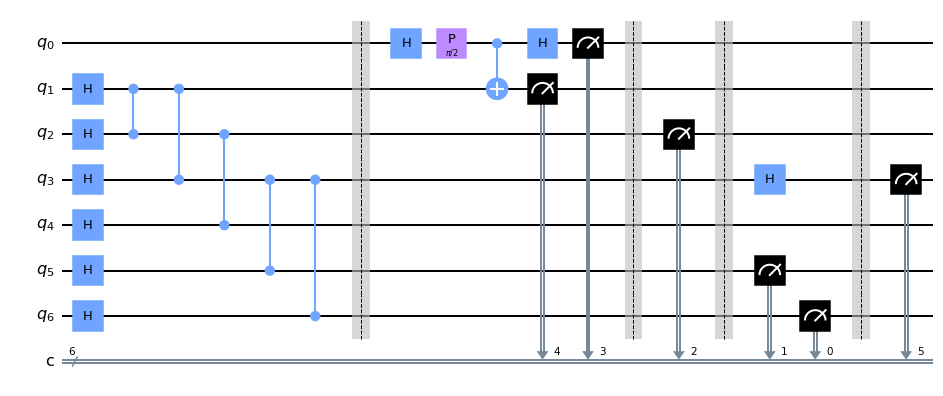

In [54]:
# Define circuit

def make_circuit(theta, direction, meas_dir):
    """
    theta, direction determine the initial messenger qubit; 
    meas_dir is either 'x' or 'z', determining the final measurement direction
    """
    # Initialize the circuit
    qr = QuantumRegister(7, 'q')
    cr = ClassicalRegister(6, 'c')
    circ = QuantumCircuit(qr, cr)
    for i in range(1, 7):
        circ.h(i)
    circ.cz(1, 2)
    circ.cz(1, 3)
    circ.cz(2, 4)
    circ.cz(3, 5)
    circ.cz(3, 6)
    circ.barrier()

    # Initialize messenger qubit
    if direction == 'z':
        # Start in x eigenstate, rotate about z-axis
        circ.h(0)
        circ.p(theta, 0)
    
    # Bell measurement between messenger and root qubits
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 4, x2 in cbit 3
    circ.measure(0, 3)
    circ.measure(1, 4)
    circ.barrier()

    # Store x3 in cbit 2
    circ.measure(2, 2)
    circ.barrier()

    # Measure 2nd level qubits of branch 2 in z
    circ.measure(5, 1)
    circ.measure(6, 0)

    circ.h(3)

    # Measure the encoded qubit into cbit 5
    circ.barrier()
    if meas_dir == 'z':
        circ.measure(3, 5)
    if meas_dir == 'x':
        circ.h(3)
        circ.measure(3, 5)
    
    return circ

circ = make_circuit(np.pi / 2, 'z', 'z')
circ.draw('mpl')

In [82]:
# Get the fidelities for z-sweep

backend = Aer.get_backend('qasm_simulator')

theta_list = np.linspace(0, np.pi, 20)
jobs_z = {}

for theta in theta_list:
    circ_zmeas = make_circuit(theta, 'z', 'z')
    circ_xmeas = make_circuit(theta, 'z', 'x')
    
    # Key is theta, measurement direction
    jobs_z[(theta, 'z')] = backend.run(transpile(circ_zmeas, backend), shots=10000)
    jobs_z[(theta, 'x')] = backend.run(transpile(circ_xmeas, backend), shots=10000)

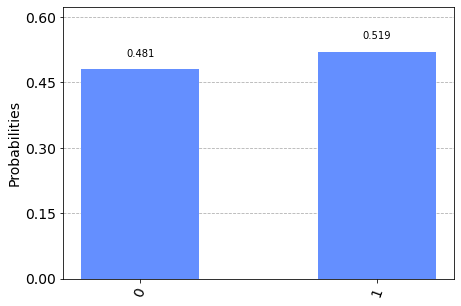

In [83]:
h_keys = ['00000', '00011', '01100', '01111', '10001', '10010', '11101', '11110']

results_z = {key : job.result() for key, job in jobs_z.items()}
fullcounts_z = {key : res.get_counts() for key, res in results_z.items()}

counts_z_filtered = {}
for key, counts in fullcounts_z.items():
    counts_z_filtered[key] = {key[0] : val for key, val in counts.items() if key[1:] in h_keys}

plot_histogram(counts_z_filtered[(theta_list[10], 'x')])

In [58]:
import pickle
pickle.dump(counts_z_filtered, open('counts_z_filtered.p', 'wb'))

In [90]:
def reconstruct_state(z_counts, x_counts):
    """
    Given histograms for x and z measurements, 
    reconstructs the state. 
    """
    def get_basis_ratio(counts):
        if '0' not in counts.keys():
            return (0, 1)
        elif '1' not in counts.keys():
            return (1, 0)
        else:
            total = counts['0'] + counts['1']
            return (counts['0'] / total, counts['1'] / total)
        
    z_ratio = get_basis_ratio(z_counts)
    z_exp = z_ratio[0] - z_ratio[1]
    
    x_ratio = get_basis_ratio(x_counts)
    x_exp = x_ratio[0] - x_ratio[1]
    
    ysq = 1 - z_exp * z_exp - x_exp * x_exp
    if ysq < 0:
        y_exp = 0
    else:
        y_exp = np.sqrt(ysq)
    
    # Return position on the Bloch sphere
    pos = np.array([x_exp, y_exp, z_exp])
    return pos / np.linalg.norm(pos)

def bloch_to_dm(vec):
    """
    Takes in a 3-tuple corresponding to a position 
    on the Bloch sphere and returns a density matrix.
    """
    identity = np.array([[1, 0], [0, 1]])
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    sigmaz = np.array([[1, 0], [0, -1]])
    return 1/2 * (identity + vec[0] * sigmax + vec[1] * sigmay + vec[2] * sigmaz)

def state_vec(theta, direction='z'):
    if direction == 'z':
        circ = QuantumCircuit(1)
        circ.h(0)
        circ.p(theta, 0)
    return Statevector(circ)

def get_fidelity(theta, direction='z'):
    meas_state = reconstruct_state(counts_z_filtered[theta, 'z'], counts_z_filtered[theta, 'x'])
    meas_dm = DensityMatrix(bloch_to_dm(meas_state))
    true_state = state_vec(theta, direction)
    return state_fidelity(meas_dm, true_state)

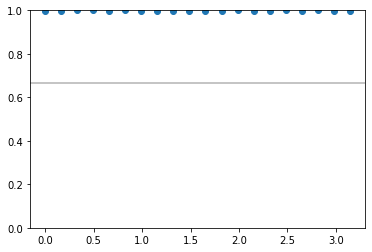

In [93]:
fidelities_z = {theta : get_fidelity(theta, 'z') for theta in theta_list}
plt.scatter(theta_list, fidelities_z.values())
plt.axhline(y=0.666, color='grey', alpha=0.6)
plt.ylim((0, 1))
plt.show()